# CAB420, DCNNs, Example 4: Breaking VGG
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
The initial DCNNs we've looked at, and those in the literature, simply relied on stacking layers one on top of the other, with up to a few convoluations followed by a max-pooling operation to reduce the resolution, and then a repeat of this until a sufficient number of layers was reached. More layers was seen as better, as it allowed for richer and richer representations. However, after a while performance stops improving, and can in fact go backwards. This example simply explores this.

This example is pretty light in terms of explanation of the networks, etc. If you're unclear what's happening in places, go back and revise the previous DCNN examples.

## To Long; Didn't Read:
* Although deeper networks generally offer better accuracy, there is a limit to how deep we can go
* After a certain point, we simply can't learn meaninful representations in all the layers, it gets hard to propogate information that far and while batch normalisation can help prevent vanishing gradients, it doesn't solve the problem
* In this example, we see that as we add more and more layers performance doesn't keep improving, and instead we get to a point where the model simply fails to learn. While we don't need 20+ conv layers for Fashion MNIST, for bigger and more varied situations being able to get to deeper networks would be desireable.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Data: Fasion M-NIST
Enough said.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

In [3]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)

## A Sensible Network

This is like what we've before. A series of convoluation and max-pools, then a fully connected layer.

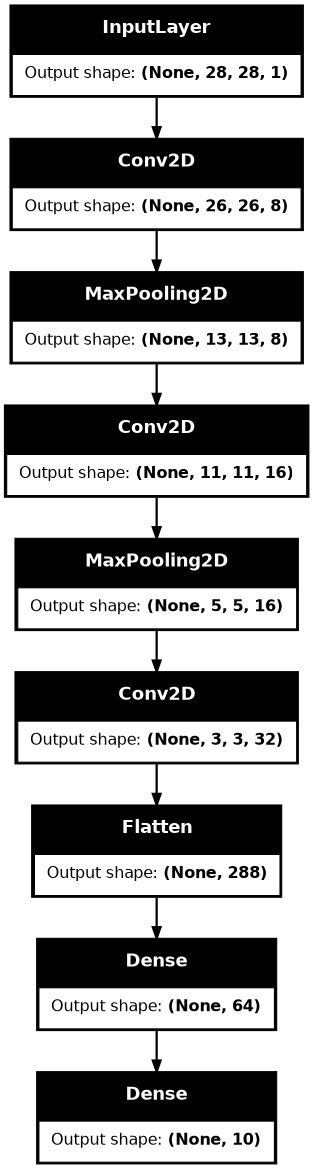

In [4]:
# build the network
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')

keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80)

In [5]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2)

def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6740 - loss: 0.9163 - val_accuracy: 0.8191 - val_loss: 0.4882
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8281 - loss: 0.4710 - val_accuracy: 0.8474 - val_loss: 0.4129
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8524 - loss: 0.4026 - val_accuracy: 0.8470 - val_loss: 0.4070
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8700 - loss: 0.3565 - val_accuracy: 0.8736 - val_loss: 0.3476
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8783 - loss: 0.3293 - val_accuracy: 0.8760 - val_loss: 0.3370
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8885 - loss: 0.3058 - val_accuracy: 0.8823 - val_loss: 0.3276
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8911 - loss: 0.2921 - val_accuracy: 0.8825 - val_loss: 0.3220
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8989 - loss: 0.2746 - val_accuracy: 0.

In terms of performance, this works ok. 

313/313 - 1s - 3ms/step - accuracy: 0.8870 - loss: 0.3149
Test loss: 0.31490230560302734
Test accuracy: 0.8870000243186951
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


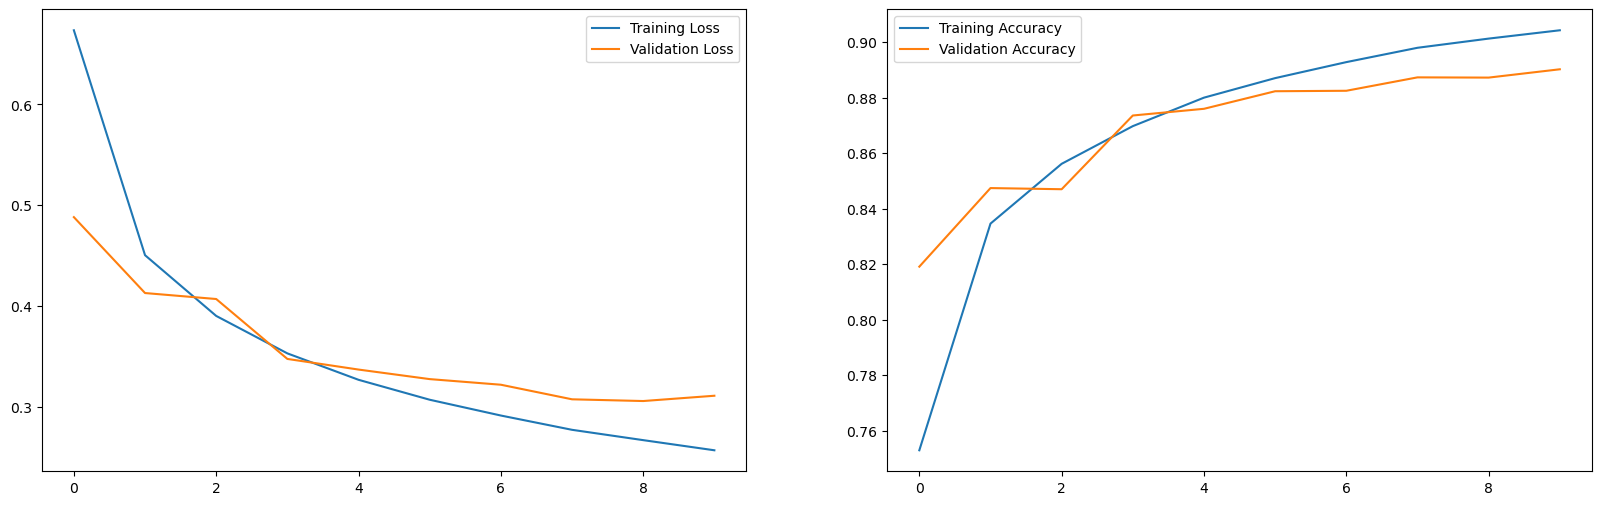

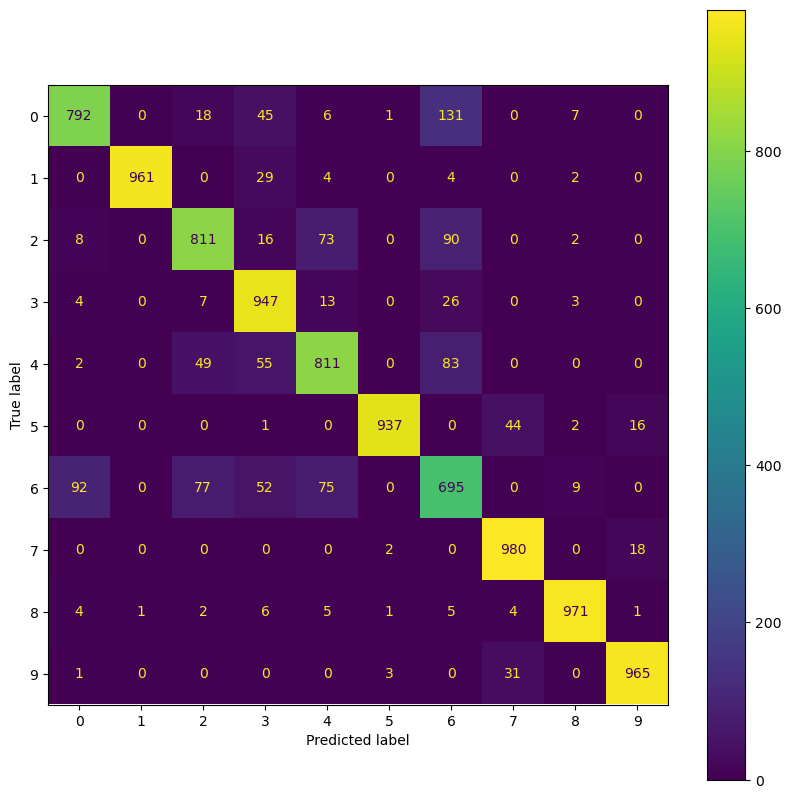

In [6]:
plot_training(history)
eval_model(model_cnn, x_test, y_test)

## Another Sensible Network

Now we stack our convolutions, just two deep. We've seen this before, and this is what we normally think of as a "VGG-Type" network with the stacked convolutions.

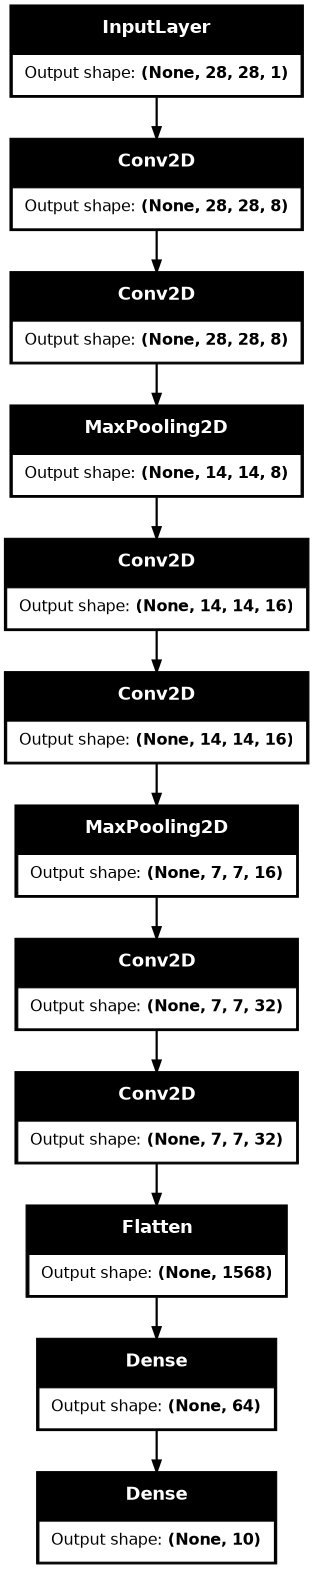

In [7]:
# build the network
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80)

In [8]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6988 - loss: 0.8158 - val_accuracy: 0.8664 - val_loss: 0.3642
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8761 - loss: 0.3428 - val_accuracy: 0.8802 - val_loss: 0.3314
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8933 - loss: 0.2892 - val_accuracy: 0.8983 - val_loss: 0.2776
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9061 - loss: 0.2528 - val_accuracy: 0.9100 - val_loss: 0.2592
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9166 - loss: 0.2238 - val_accuracy: 0.9057 - val_loss: 0.2606
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9250 - loss: 0.2054 - val_accuracy: 0.9073 - val_loss: 0.2647
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9301 - loss: 0.1895 - val_accuracy: 0.9148 - val_loss: 0.2414
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9352 - loss: 0.1760 - val_accuracy: 0.

Once again, this works pretty well.

313/313 - 1s - 4ms/step - accuracy: 0.9132 - loss: 0.2469
Test loss: 0.24691641330718994
Test accuracy: 0.9132000207901001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


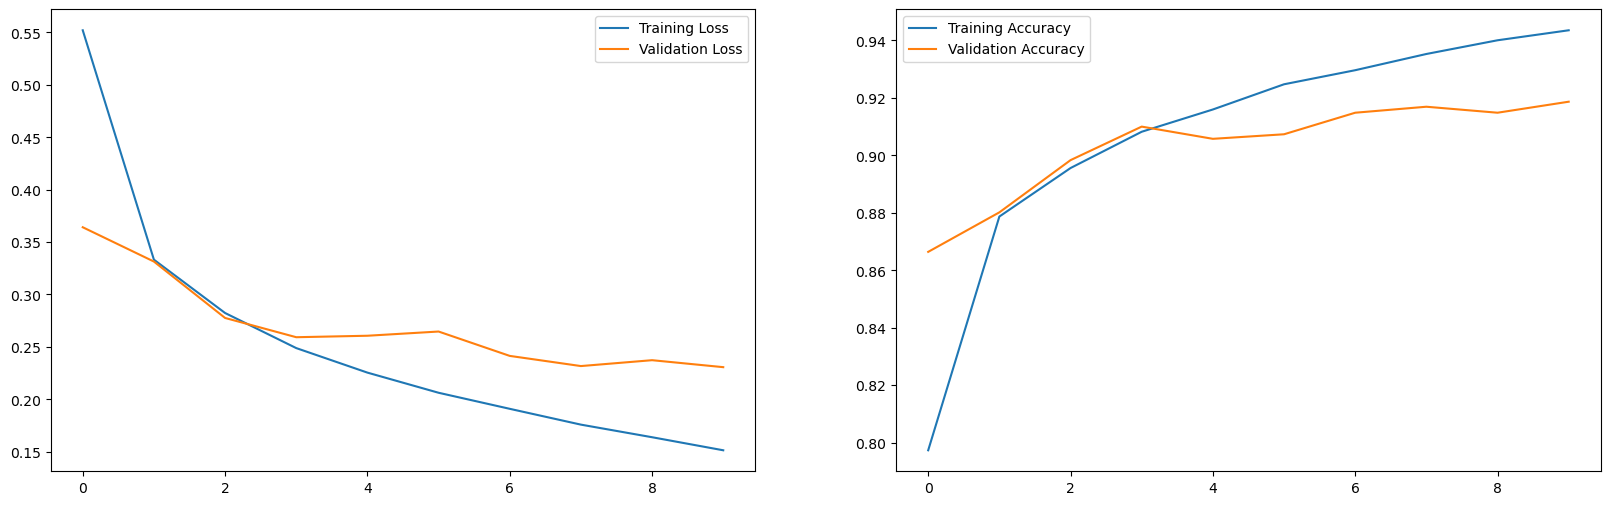

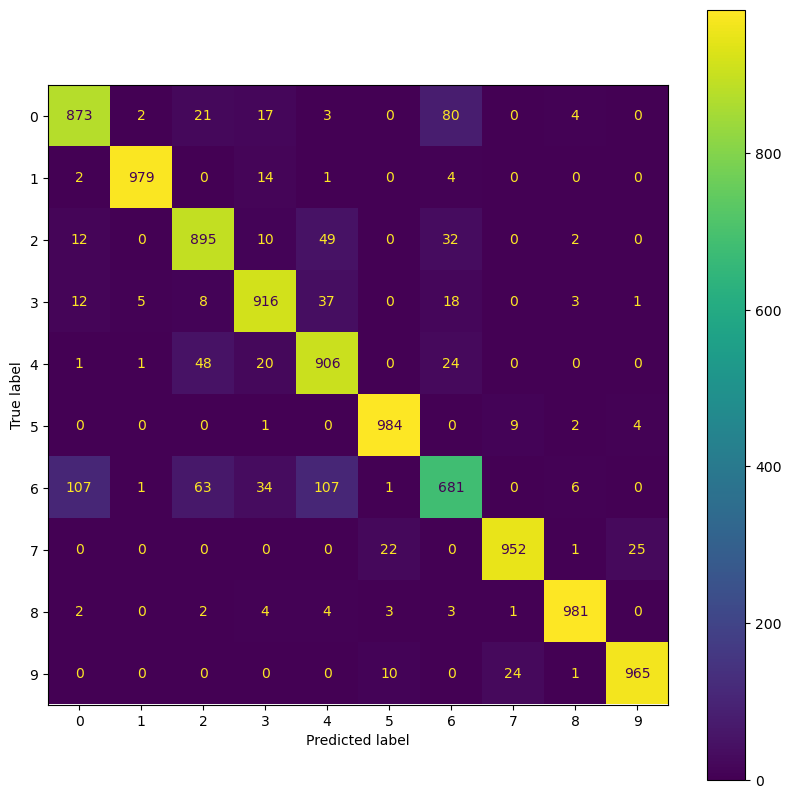

In [9]:
plot_training(history)
eval_model(model_cnn, x_test, y_test)

## A Less Sensible Network

If stacking two convolutions works, what about 6?

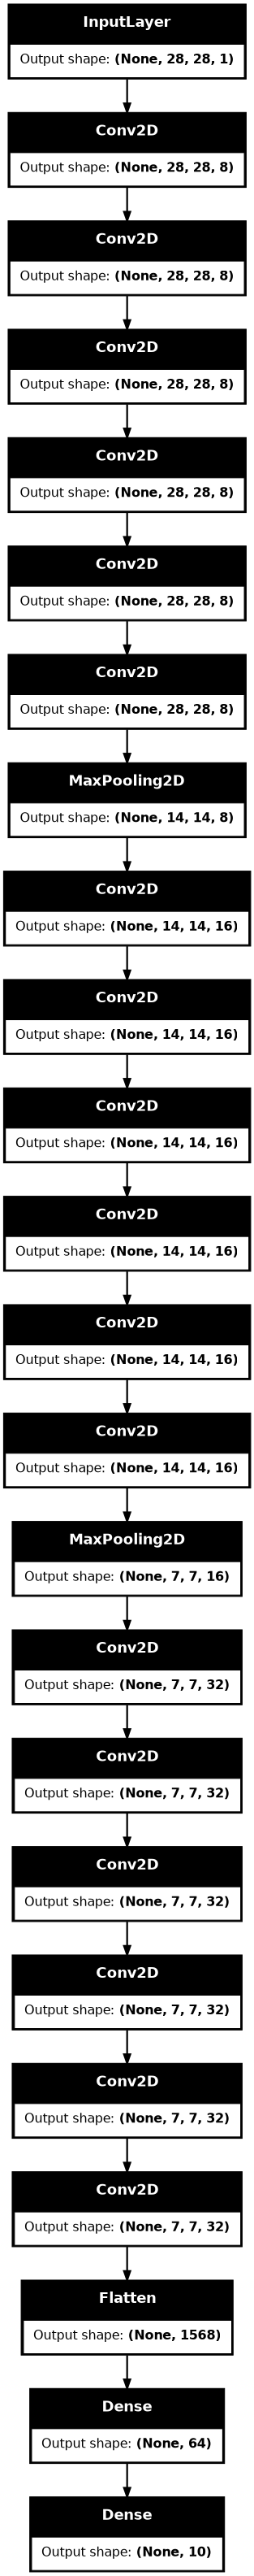

In [10]:
# build the network
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80)

In [11]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3896 - loss: 1.5977 - val_accuracy: 0.8172 - val_loss: 0.5083
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8322 - loss: 0.4511 - val_accuracy: 0.8653 - val_loss: 0.3678
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8635 - loss: 0.3601 - val_accuracy: 0.8777 - val_loss: 0.3264
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8772 - loss: 0.3187 - val_accuracy: 0.8733 - val_loss: 0.3495
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8873 - loss: 0.2994 - val_accuracy: 0.8870 - val_loss: 0.3099
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8980 - loss: 0.2742 - val_accuracy: 0.8905 - val_loss: 0.3006
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9017 - loss: 0.2603 - val_accuracy: 0.8960 - val_loss: 0.2842
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9097 - loss: 0.2360 - val_accuracy: 0.

Still works - though we're not seeing any massive improvement here either. Really, it's about the same performance for a lot more computational costs. In saying that, we could (should) train this for longer to get optimal performance.

313/313 - 1s - 2ms/step - accuracy: 0.8986 - loss: 0.2745
Test loss: 0.27449581027030945
Test accuracy: 0.8985999822616577
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


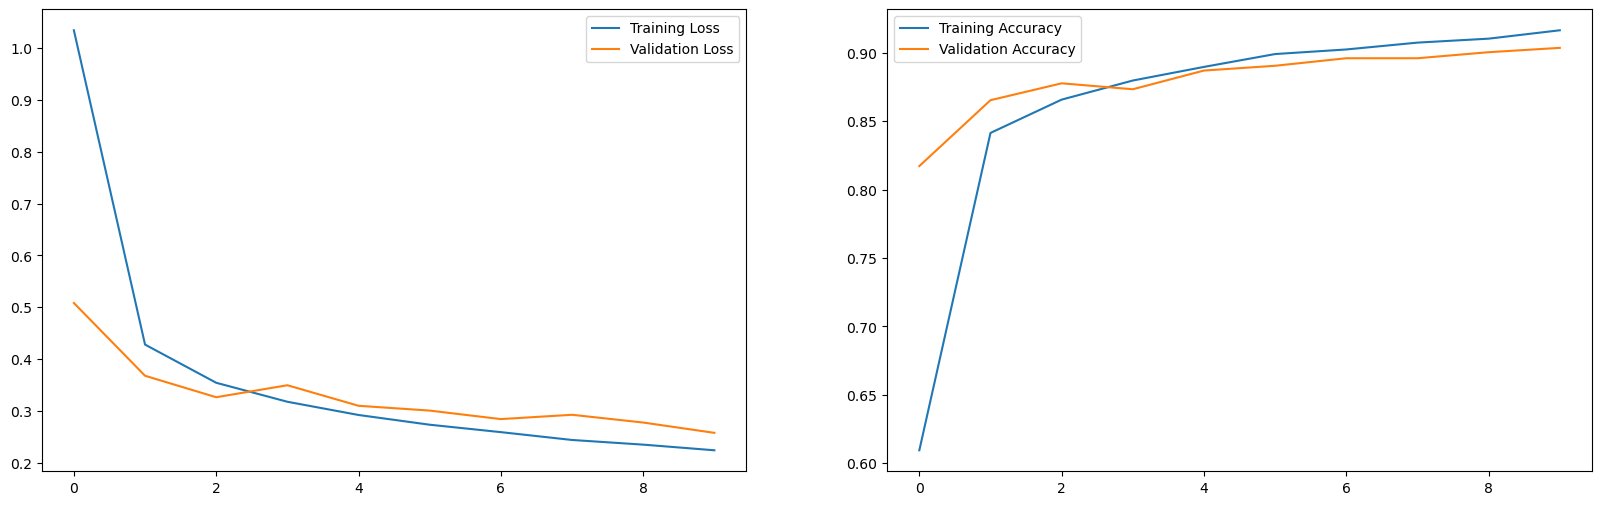

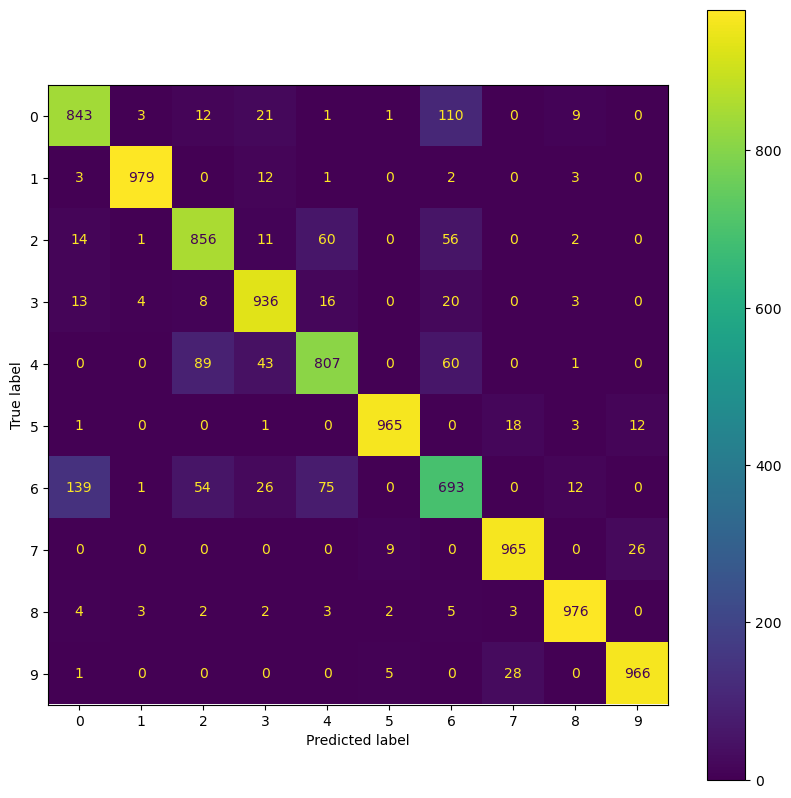

In [12]:
plot_training(history)
eval_model(model_cnn, x_test, y_test)

## A Silly Network

If something is worth doing, it's worth overdoing. We now have stacks of 10 convolutions.

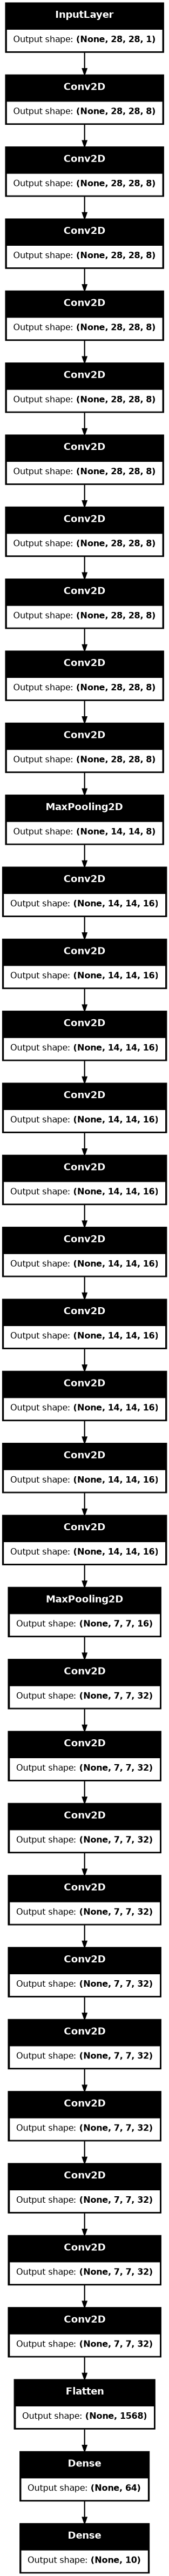

In [13]:
# build the network
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation=None)(x)

# build the model, and print the summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80)

In [14]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.1015 - loss: 2.3028 - val_accuracy: 0.1003 - val_loss: 2.3026
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0984 - loss: 2.3027 - val_accuracy: 0.0983 - val_loss: 2.3026
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1013 - loss: 2.3026 - val_accuracy: 0.1013 - val_loss: 2.3027
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0976 - loss: 2.3026 - val_accuracy: 0.0983 - val_loss: 2.3027
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1004 - loss: 2.3027 - val_accuracy: 0.1003 - val_loss: 2.3026
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1024 - loss: 2.3027 - val_accuracy: 0.1013 - val_loss: 2.3026
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1000 - loss: 2.3027 - val_accuracy: 0.0957 - val_loss: 2.3027
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.0991 - loss: 2.3027 - val_acc

It's broken. We fail to train, and performance sits at around that of random chance.

313/313 - 1s - 3ms/step - accuracy: 0.1000 - loss: 2.3027
Test loss: 2.3026554584503174
Test accuracy: 0.10000000149011612
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


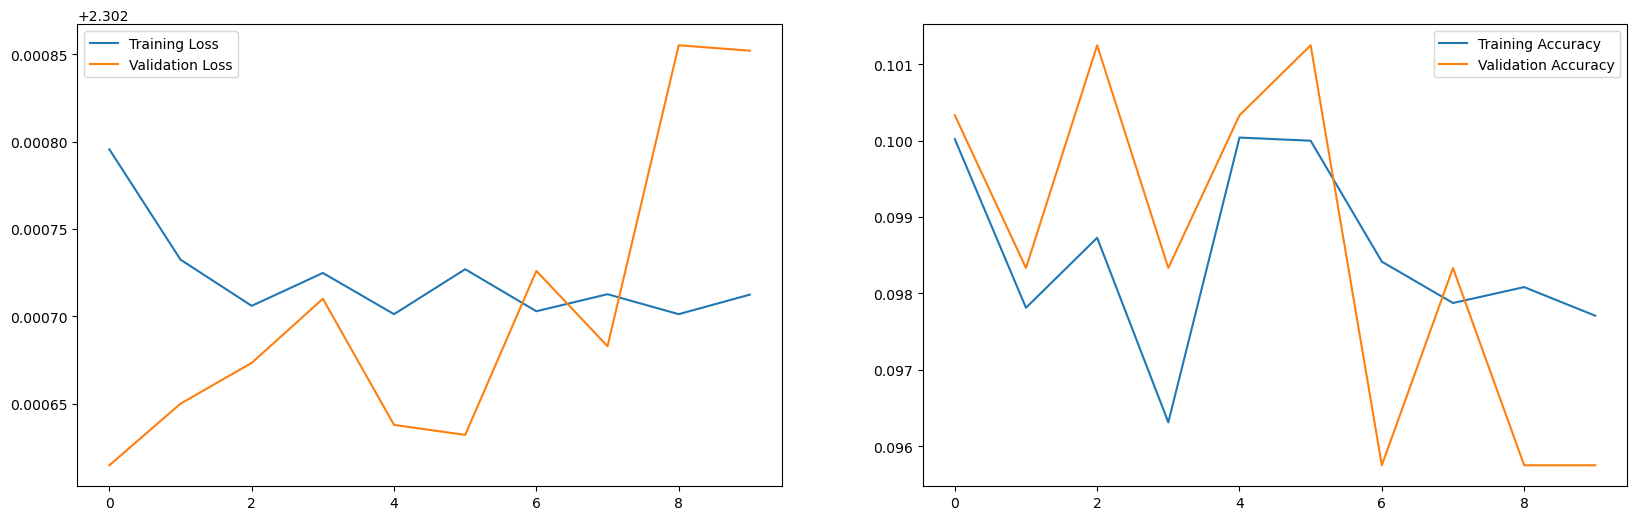

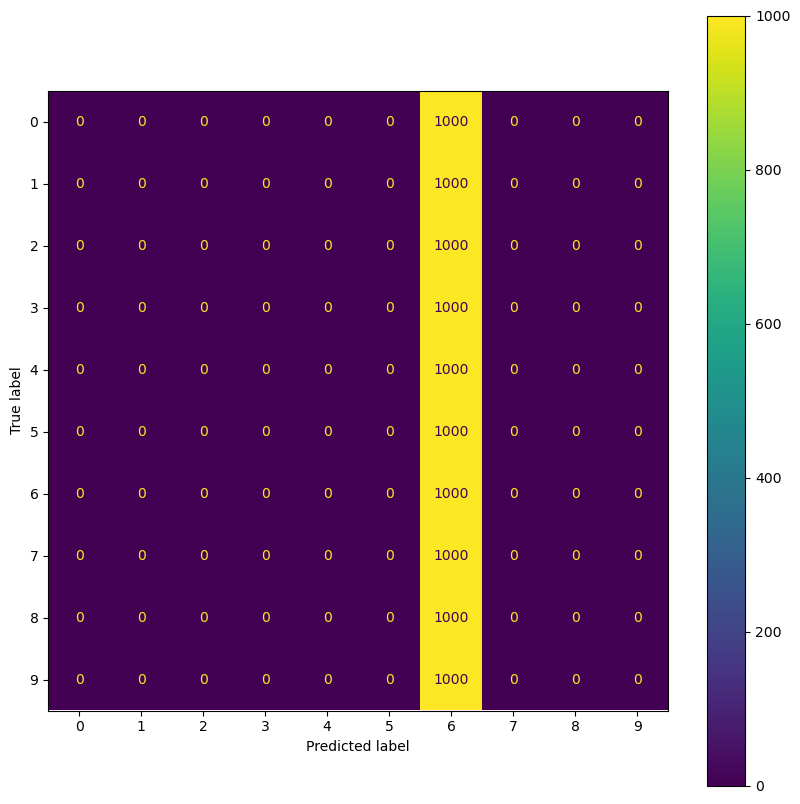

In [15]:
plot_training(history)
eval_model(model_cnn, x_test, y_test)

And at this point we've reached the stage where we fail to learn anything. The network has become too deep, and nothing of any meaning gets through in terms of gradients and back-propogation. Basically, our first layer is just too far away from the final layer and loss function, and the gradients are too small by the time they get back to the early layers to make any meaninful updates. This is the vanishing gradient problem.

There are a bunch of things we could do to help this, including batch normalisation, which will help make intermediate represntations more stable. However, even with this we'd still just encouter this again once we add a few more layers.

## Final Thoughts

We see that as we get deeper, we don't necessarily get better performance. There is a point at which we can't just keep going deeper and deeper. It gets harder to learn a good representation, and if we keep going we get to a point where training just fails.

Despite this there is a desire to go deeper. Deeper networks allow for richer representations. Looking at it simply, the first layer learns edges, the second shapes, the third might find small structures such as the eyes or nose, and then the fourth can find faces. It's not quite like that (though it's not that far off either), but the basic idea is that by having more and more stacked layers we can learn more and more complex representations. So we'd like to find a way around this. The big problem we have is getting a path back from the output to the input. If we have to go through too many layers, this becomes hard and the error gradients get lost and vanish, and we can't learn those early layers. What we really need is a way to take a shortcut back to the input.

Enter, the residual network.